## Forecasting iPad Sales Using Prophet

*Nathan Brixius, April 2017*

In this notebook I will demonstrate the use of Facebook's Prophet forecasting library to predict the future quarterly sales of iPads. [Read about Prophet here](https://research.fb.com/prophet-forecasting-at-scale/), and [install Prophet using these instructions](https://facebookincubator.github.io/prophet/docs/quick_start.html).

This scenario doesn't seem to be ideally suited for Prophet - if you scroll to the bottom you'll see that the forecast is not particularly amazing - but I think it's worth sharing anyway.

First, we'll import the libraries we're going to need, including Prophet:

In [9]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

I'd like to use Prophet to predict quarterly units sales for the Apple iPad. We'll start by creating a Pandas DataFrame containing past quarterly sales data. This is easy to find, for example in [Apple's quarterly reports](http://investor.apple.com/) or [elsewhere on the web](https://www.statista.com/statistics/269915/global-apple-ipad-sales-since-q3-2010/). To make this notebook self-contained I've simply entered the sales data into the cell below, but in practice it's better to read it from a CSV file using pd.read_csv.

The data frame contains a column named _y_ with unit sales in millions, and a column named _ds_ with the end date of each Apple financial quarter. Prophet expects input data to be structured in this way. (By the way, the end-of-quarter dates aren't exact, but they are close enough.)

In [4]:
ds = ['6/21/2010','9/20/2010','12/27/2010',
      '3/23/2011','6/22/2011','9/21/2011','12/28/2011',
      '3/23/2012','6/22/2012','9/21/2012','12/28/2012',
      '3/24/2013','6/23/2013','9/22/2013','12/29/2013',
      '3/25/2014','6/24/2014','9/23/2014','12/30/2014',
      '3/26/2015','6/25/2015','9/24/2015','12/31/2015',
      '3/26/2016','6/25/2016','9/24/2016','12/31/2016']
y = [3.27, 4.19, 7.33,
     4.69, 9.25, 11.12, 15.43,
     11.8, 17.04, 14.04, 22.86,
     19.48, 14.62, 14.08, 26.04,
     16.35, 13.28, 12.32, 21.42,
     12.62, 10.93, 9.88, 16.12,
     10.25, 9.95, 9.27, 13.08]
df = pd.DataFrame(data={'ds': ds, 'y': y})

Let's look at the sales data using matplotlib. We see that sales increase rapidly during the first few quarters of the iPad's introduction, and then stabilize. We also see that there are clearly seasonal patterns in the data, particuarly the last quarter of each calendar year where there are presumably lots of holiday buyers.

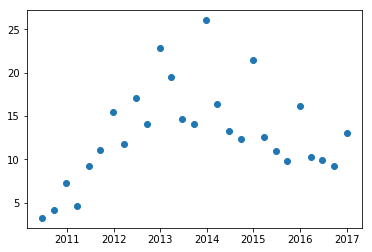

In [10]:
ds = list(map(mdates.strpdate2num('%m/%d/%Y'), df['ds']))
plt.plot_date(ds, df['y'])

Since this data shows a growth pattern, we'll take the log of sales (which is a very common technique) and use Prophet's 'growth' feature when we actually do the forecasting.

In [15]:
df['y'] = np.log(df['y'])

Seasonality does not appear to capture all of the patterns we see in the data. For example, there's a very large spike at the beginning of 2014, and we know that [the release of the iPad Air was in November 2013](https://en.wikipedia.org/wiki/IPad#Model_comparison). Perhaps we should incorporate iPad release dates into our model. Prophet allows you to do this using their ['holidays' feature](https://facebookincubator.github.io/prophet/docs/holiday_effects.html). This feature is misnamed because it can be used for any event of importance to our forecast - [luckily it looks like this may be addressed in a future release](https://github.com/facebookincubator/prophet/issues/38).

Each entry in the holidays data frame needs to have a categorization (in this case 'release'), and you can optionally specify upper and lower bounds on the range around each 'holiday' that may be impacted by the event. I have set this window to be one quarter after each product release.

In [16]:
h = pd.DataFrame({
    'holiday': 'release',
    'ds': ['4/3/2010', '3/11/2011', '11/2/2012', '11/1/2013', '10/22/2014', '3/24/2017'],
    'lower_window': 0.0,
    'upper_window': 366/4
  })

Now that we have sales and event information, we're ready to forecast. The Prophet functions that you typically want to use are __fit__, __make\_future\_dataframe__, and __predict__.'

Since sales grow and then more-or-less level off, we'll use the logistic growth option when we create the Prophet object. The documentation tells us that we need to specify a 'cap' which is the likely maximum sales we're likely to encounter. We set this to a small factor above maximimum historical sales.

In [20]:
m = Prophet(growth='logistic', holidays=h)
cap = 1.1 * np.max(df['y'])
df['cap'] = cap
fit = m.fit(df)

Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Now we want to predict sales for future quarters. When we call __predict__ we need to feed it a data frame with the dates we want Prophet to estimate sales for. __make\_future\_dataframe__ is a helper function for this purpose. The magic constant 'BQ' indicates that we want the next four business quarters, [see here for more](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases).

In [21]:
future = m.make_future_dataframe(periods=4, freq='BQ')
future['cap'] = cap
forecast = fit.predict(future)

Now we can inspect the results using the __plot__ method. What we see is that Prophet does a pretty decent job of matching the historical (training) time period. We see that sales appear to take an unrealistically step drop for the first couple of future quarters, and then a large spike.

If you play around with some of the other options in Prophet, you can get a future forecast that looks a little more 'plausible'. I will leave that up to you.

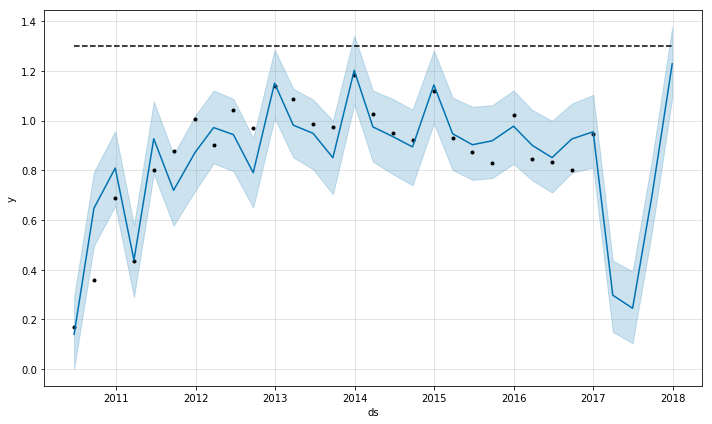

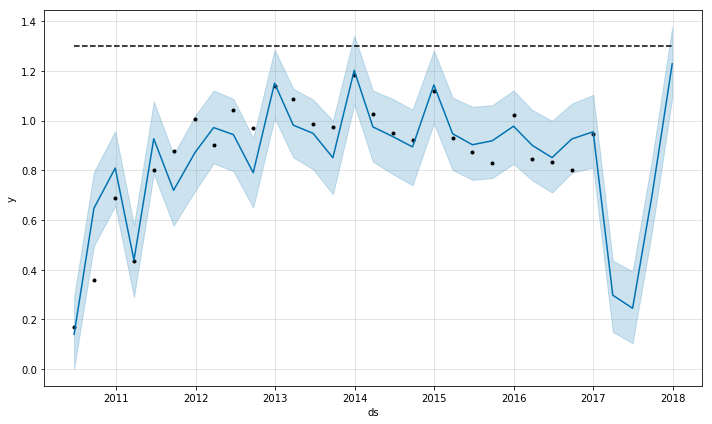

In [22]:
m.plot(forecast)

Another useful Prophet feature is __plot\_components__. This displays time series of each of the components that make up the total sales forecast, including the estimated impact of product releases (holidays).

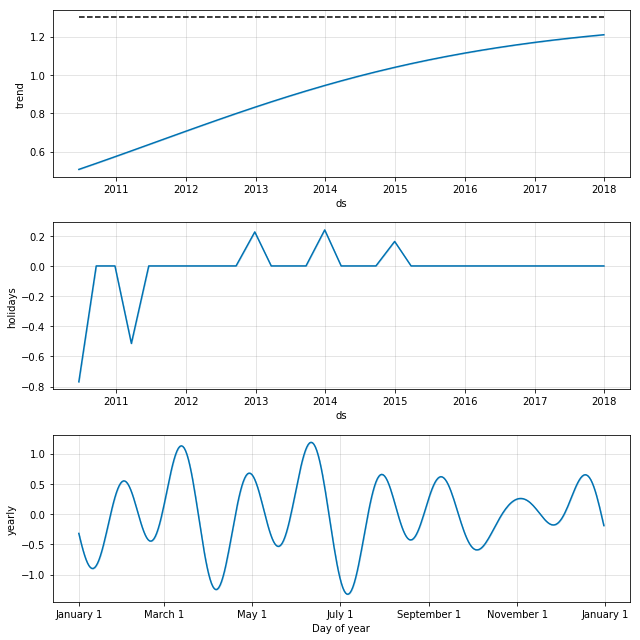

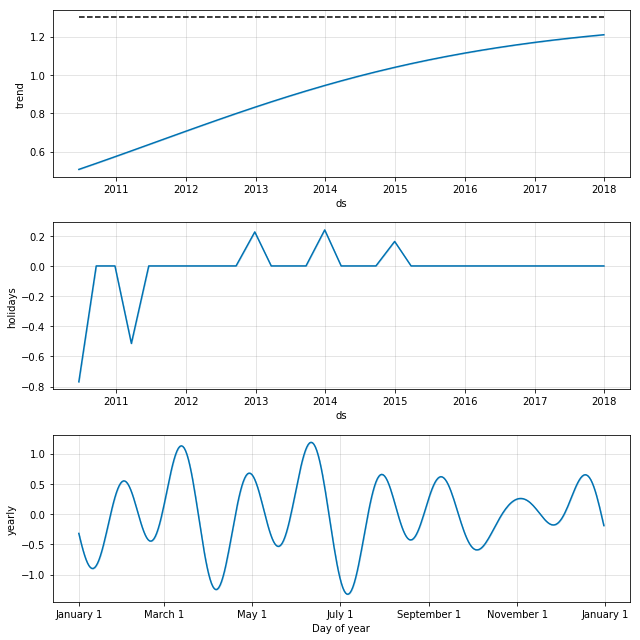

In [23]:
m.plot_components(forecast)

That's a wrap. I certainly like the simplicity of the API and integration with visualization. If the feature set continues to develop then Prophet may become a practical tool for professional scenarios.